In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import geopandas

import warnings

warnings.filterwarnings('ignore')

C:\Users\aglar\AppData\Local\anaconda3\envs\pycharm\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
file_name = f'./dbs/intermediate/stops_1_new.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

df = df.drop(['holiday_s', 'weekday_s'], axis=1)

In [4]:
df.drop_duplicates(subset=['uid','cluster'], keep='first', inplace=True)

## read the detected home and work locations

In [5]:
df_h = pd.read_parquet(f'./dbs/intermediate/home_inference.parquet')
df_h.drop_duplicates(subset='uid', keep='first', inplace=True)
df_h['home_potential'] = 1

df_w = pd.read_parquet(f'./dbs/intermediate/work_inference.parquet')
df_w.drop_duplicates(subset='uid', keep='first', inplace=True)


In [6]:
df_1 = pd.merge(df, df_h[['uid','cluster','home_potential' ]], on= ['uid','cluster'], how="left")

df_1 = pd.merge(df_1, df_w[['uid','cluster','work_potential' ]], on= ['uid','cluster'], how="left")


df_1.fillna(value={"home_potential": 0, "work_potential": 0}, inplace=True)

df_1[['home_potential','work_potential']] = df_1[['home_potential','work_potential']].astype(int)
# df_1 = df_1[df_1.score.isnull()]
# df_1.drop(columns=['score'], inplace=True)

## keep only people with detected home locations

In [7]:
ppl_having_home = list(df_1['uid'][df_1.home_potential==1].unique())
df_1 = df_1[df_1.uid.isin(ppl_having_home)]

In [8]:
df_2 = df_1[(df_1.home_potential==1)|(df_1.work_potential==1)]

## intersect clusters with DeSO zones

In [9]:
gdf_2 = geopandas.GeoDataFrame(df_2, geometry=geopandas.points_from_xy(df_2.cluster_lng, df_2.cluster_lat), crs="EPSG:4326")

gdf_2.drop("Deso", axis=1, inplace=True)


In [10]:
DeSO = geopandas.read_file(
    f'C:/Synthetic_population_new/caglar/synthetic_sweden/input/deso_statistik_shp/Bef_Kon_region.shp')

print(DeSO.crs)

DeSO.to_crs(4326, inplace=True)
print(DeSO.crs)

PROJCS["SWEREF99 TM",GEOGCS["SWEREF99",DATUM["SWEREF99",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6619"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3006"]]
epsg:4326


In [11]:
gdf_2 = gdf_2.sjoin(DeSO[['Deso','geometry']], how="left")


## home detection evaluation by DeSO zones

In [12]:
gdf_2_home = gdf_2[gdf_2.home_potential== 1]

gdf_2_home= gdf_2_home.groupby('Deso')['uid'].count().reset_index().rename(columns={"uid":'home_count'})


In [13]:
gdf_2_home = pd.merge(DeSO, gdf_2_home, left_on=['Deso'], right_on=['Deso'], how="left")


In [14]:
gdf_2_home['home/pop'] = gdf_2_home['home_count']/gdf_2_home['Totalt'] * 100
gdf_2_home['urban_density'] =gdf_2_home['Deso'].str[4]

In [15]:
from scipy.stats import spearmanr

# Calculate Spearman correlation coefficient
rho, p_value = spearmanr(gdf_2_home['home_count'], gdf_2_home['Totalt'])

# Display the result
print(f"Spearman correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.4910496187866488
P-value: 0.0


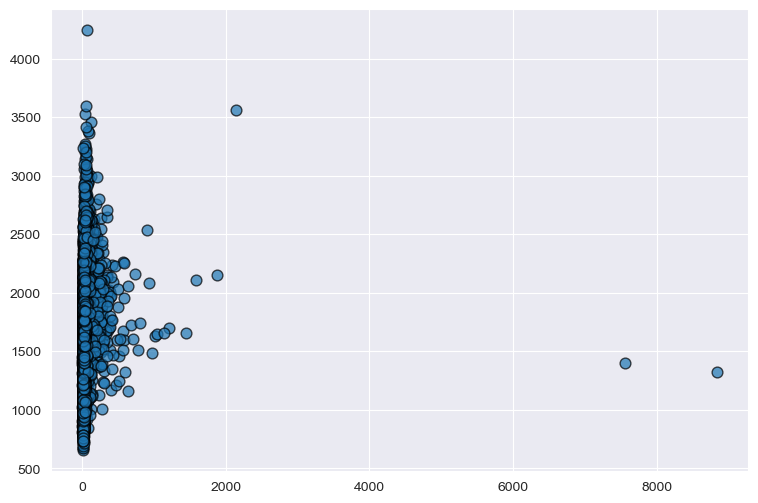

In [16]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(gdf_2_home['home_count'], gdf_2_home['Totalt'], s=60, alpha=0.7, edgecolors="k")



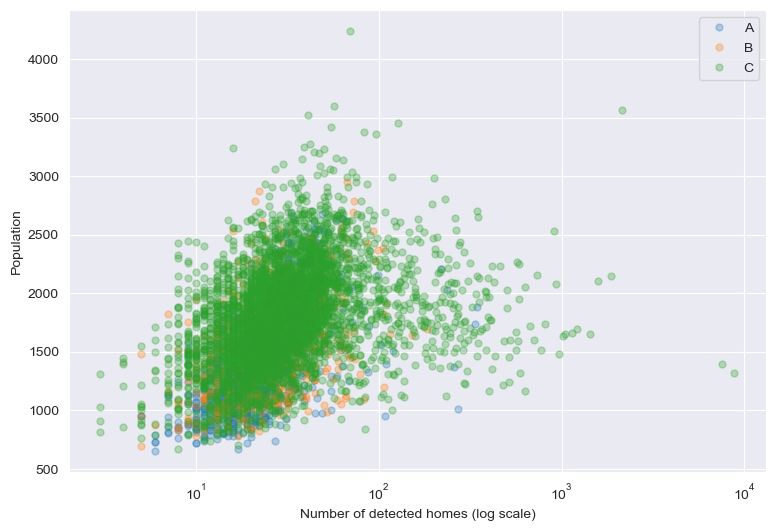

In [17]:
fig, ax = plt.subplots(figsize = (9, 6))

groups = gdf_2_home.groupby('urban_density')
for name, group in groups:
    ax.plot(group['home_count'], group['Totalt'], marker='o', linestyle='', alpha=0.3, markersize=5, label=name)
ax.set_xscale("log")
ax.set_xlabel("Number of detected homes (log scale)")
ax.set_ylabel("Population")

plt.legend()

plt.savefig("./figures/deso_pop_vs_detected_house_scatter.png")

In [18]:
print('95 percentiles: '+ str(gdf_2_home['home/pop'].quantile(0.95)))
print('The number of outliers: '+ str(len(gdf_2_home[gdf_2_home['home/pop']> 100])))


95 percentiles: 5.471611829915401
The number of outliers: 2


In [19]:
gdf_2_home = gdf_2_home[gdf_2_home["home/pop"]<100]

gdf_2_home_json = gdf_2_home[['Deso','geometry']].to_json()


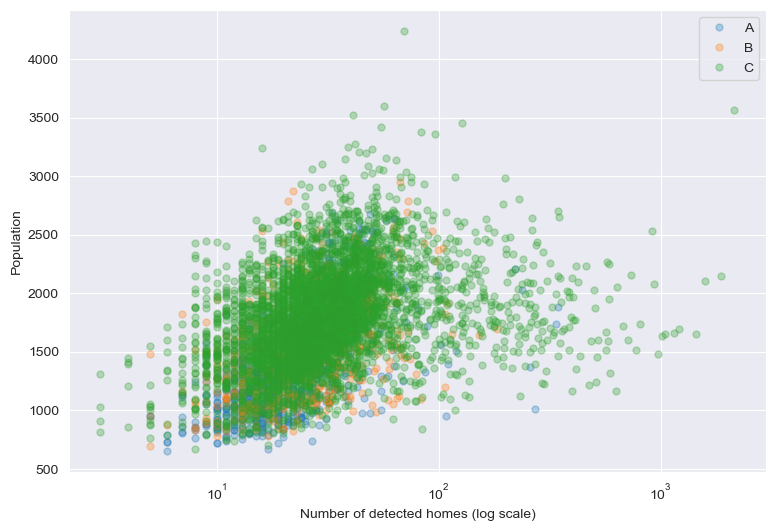

In [20]:
fig, ax = plt.subplots(figsize = (9, 6))

groups = gdf_2_home.groupby('urban_density')
for name, group in groups:
    ax.plot(group['home_count'], group['Totalt'], marker='o', linestyle='', alpha=0.3, markersize=5, label=name)
ax.set_xscale("log")
ax.set_xlabel("Number of detected homes (log scale)")
ax.set_ylabel("Population")

plt.legend()

plt.savefig("./figures/deso_pop_vs_detected_house_scatter.png")

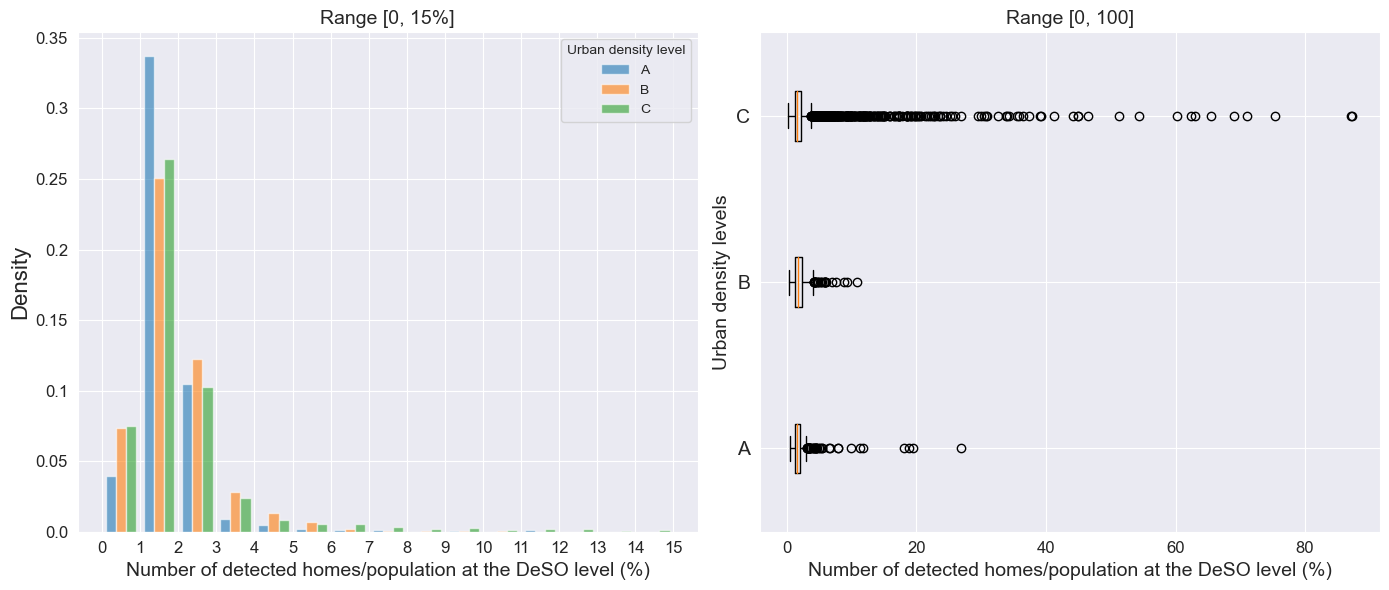

In [21]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

all_data = [gdf_2_home['home/pop'][gdf_2_home.urban_density== i] for i in ['A','B','C']]

ax0.hist(all_data, density=True, histtype='bar', label=['A','B','C'], alpha=0.6, bins=range(0,16,1))
ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
ax0.set_xlabel('Number of detected homes/population at the DeSO level (%)', fontsize=14)
ax0.set_title('Range [0, 15%]', fontsize=14)
#ax0.set_xticklabels(np.arange(-6, 31, step=6), fontsize=12)
ax0.set_xticks(range(0,16,1),range(0,16,1), fontsize=12)
ax0.set_yticklabels(np.round(np.arange(0, 0.5, step=0.05),2), fontsize=12)
ax0.set_ylabel('Density', fontsize=16)


ax1.boxplot(all_data, vert=False)
ax1.set_title('Range [0, 100]', fontsize=14)
ax1.set_yticks([y + 1 for y in range(len(all_data))],
                  labels=['A', 'B', 'C'], fontsize=14)
#ax1.set_xticks([1,2,3,4,5,6],labels=[range(0,101,20)], fontsize=14)

ax1.set_xticklabels(range(-20,101,20), fontsize=12)
ax1.set_ylabel('Urban density levels', fontsize=14)
ax1.set_xlabel('Number of detected homes/population at the DeSO level (%)', fontsize=14)

#fig.suptitle('Detected homes vs population', fontsize=14)

fig.tight_layout()
plt.savefig("./figures/deso_pop_vs_detected_house_histogram.png")


In [22]:
import folium

m = folium.Map(location=[60, 15], zoom_start=5)

folium.Choropleth(
    geo_data=gdf_2_home_json,
    name="choropleth",
    data=gdf_2_home,
    columns=["Deso", "home/pop"],
    key_on='feature.properties.Deso',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="The number of detected home / Population at DeSO (%)",
).add_to(m)

folium.LayerControl().add_to(m)

# Display the Choropleth
m.save('./figures/deso_pop_vs_detected_house.html')

## work detection evaluation by DeSO zones


In [23]:
gdf_2_work = gdf_2[gdf_2.work_potential== 1]

gdf_2_work= gdf_2_work.groupby('Deso')['uid'].count().reset_index().rename(columns={"uid":'work_count'})


In [24]:
gdf_2_work = pd.merge(DeSO, gdf_2_work, left_on=['Deso'], right_on=['Deso'], how="left")
gdf_2_work['work_count'] = gdf_2_work['work_count'].fillna(0).astype(int)

gdf_2_work['work/pop'] = gdf_2_work['work_count'] / gdf_2_work['Totalt'] * 100
gdf_2_work['urban_density'] = gdf_2_work['Deso'].str[4]



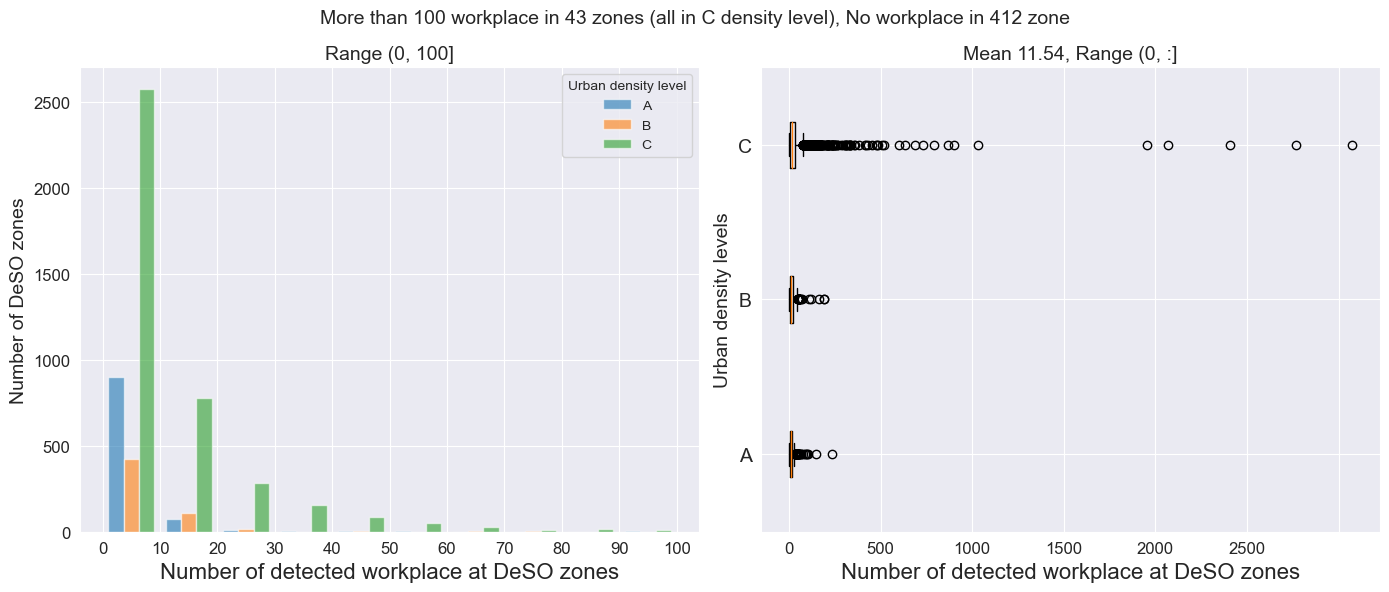

In [25]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

all_data = [gdf_2_work['work_count'][(gdf_2_work.urban_density== i)&(gdf_2_work['work_count']>0)] for i in ['A','B','C']]

ax0.hist(all_data, density=False, histtype='bar', label=['A','B','C'], alpha=0.6, bins=range(0,101,10))
ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
ax0.set_xlabel('Number of detected workplace at DeSO zones', fontsize=16)
ax0.set_title('Range (0, 100]', fontsize=14)
ax0.set_xticks(range(0,101,10),range(0,101,10), fontsize=12)
ax0.set_yticklabels(range(0, 2501, 500), fontsize=12)
ax0.set_ylabel('Number of DeSO zones', fontsize=14)


ax1.boxplot(all_data, vert=False)
ax1.set_title('Mean %s'%np.round(gdf_2_work['work_count'][(gdf_2_work.urban_density.isin(['A','B','C']))&(gdf_2_work['work_count']>0)].mean(),2)+', Range (0, :]', fontsize=14)
ax1.set_yticks([y + 1 for y in range(len(all_data))],
                   labels=['A', 'B', 'C'], fontsize=14)
# #ax1.set_xticks([1,2,3,4,5,6],labels=[range(0,101,20)], fontsize=14)
#
ax1.set_xticklabels(range(-500, 2501, 500), fontsize=12)
ax1.set_ylabel('Urban density levels', fontsize=14)
ax1.set_xlabel('Number of detected workplace at DeSO zones', fontsize=16)

fig.suptitle('More than 100 workplace in %s zones (all in C density level),'%len(gdf_2_work[(gdf_2_work.urban_density=='C')&(gdf_2_work['work_count']>100)])+' No workplace in %s zone'%len(gdf_2_work[gdf_2_work['work_count']<1])
, fontsize=14)
fig.tight_layout()
plt.savefig("./figures/deso_pop_vs_detected_work_histogram.png")


## Commuting distance

In [26]:
gdf_2_sweref = gdf_2.to_crs(3006, inplace=False)
#gdf_commute= gdf_2_sweref[gdf_2_sweref.work_potential== 1]

In [27]:
gdf_commute= gdf_2_sweref[gdf_2_sweref.uid.duplicated(keep=False)]

gdf_commute_first = gdf_commute[gdf_commute.uid.duplicated(keep='first')].set_index('uid')
gdf_commute_last = gdf_commute[gdf_commute.uid.duplicated(keep='last')].set_index('uid')


In [28]:
distances = gdf_commute_first.distance(gdf_commute_last, align=True).to_frame().reset_index()
distances.rename(columns={0:'distance(km)'}, inplace=True)
distances['distance(km)'] = distances['distance(km)']/1000

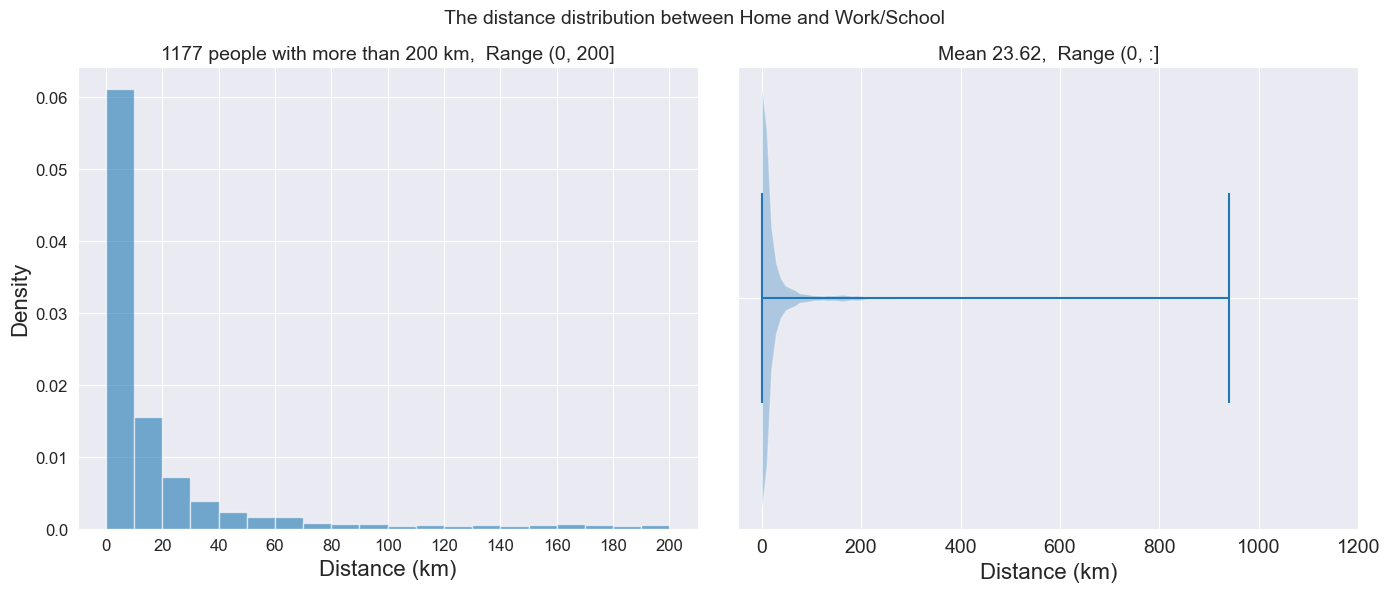

In [29]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))


ax0.hist(distances['distance(km)'][distances['distance(km)']<201], density=True, histtype='bar', alpha=0.6, bins=range(0,201,10))
#ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
ax0.set_xlabel('Distance (km)', fontsize=16)
ax0.set_title('%s people with more than 200 km'%len(distances['distance(km)'][distances['distance(km)']>200])+',  Range (0, 200]', fontsize=14)
ax0.set_xticks(range(0,201,20),range(0,201,20), fontsize=12)
ax0.set_yticklabels(np.arange(0.00, 0.07, 0.01), fontsize=12)
ax0.set_ylabel('Density', fontsize=16)


ax1.violinplot(distances['distance(km)'], vert=False)
ax1.set_title('Mean %s'%np.round(distances['distance(km)'].mean(),2)+',  Range (0, :]', fontsize=14)
ax1.set_yticks([1], labels=['   '], fontsize=14)
ax1.set_xticks(range(0,1201,200),range(0,1201,200), fontsize=14)
# #
# ax1.set_xticklabels(range(-500, 2501, 500), fontsize=12)
# ax1.set_ylabel('Urban density levels', fontsize=14)
ax1.set_xlabel('Distance (km)', fontsize=16)
#
fig.suptitle('The distance distribution between Home and Work/School' , fontsize=14)
fig.tight_layout()
plt.savefig("./figures/distance_between_Home_and_Work_School.png")


## Commuting distance MAD vs SySMO

In [30]:
df_act_plan = pd.read_pickle(r'C:\Synthetic_population\code\new_synthetic_sweden\output\synthetic_population\df_act_plan.pkl')

In [31]:
syn_pop_all = pd.read_pickle(r'C:\Synthetic_population\code\new_synthetic_sweden\output\synthetic_population\syn_pop_all.pkl')

adult_list = syn_pop_all['PId'][syn_pop_all.age>17].unique()

In [32]:
df_act_plan = df_act_plan[df_act_plan.PId.isin(adult_list)]

df_act_plan = df_act_plan[['PId', 'act_id', 'act_purpose', 'act_start',
       'act_end', 'mode', 'Deso', 'Reg_model', 'POINT_X', 'POINT_Y']]


In [33]:
df_home = df_act_plan[['PId', 'act_purpose', 'Deso', 'Reg_model', 'POINT_X', 'POINT_Y']][df_act_plan['act_purpose']==1]
df_home = df_home.drop_duplicates(['PId'])
df_home = df_home.rename(columns={'POINT_X':'X_home', 'POINT_Y':'Y_home'})
df_home = df_home.drop(columns=['act_purpose'])

df_work = df_act_plan[['PId', 'act_purpose', 'mode', 'POINT_X', 'POINT_Y']][df_act_plan['act_purpose'].isin([4])]
df_work = df_work.drop_duplicates(['PId'])
df_work = df_work.rename(columns={'POINT_X':'X_work', 'POINT_Y':'Y_work'})
df_work = df_work.drop(columns=['act_purpose'])

df_work = pd.merge(df_work, df_home, on='PId', how='left')


## haversin

df_work[['lat1','lat2','lon1','lon2']] = \
        (np.pi/180)*df_work[['Y_work','Y_home','X_work','X_home']]
df_work['dlat'] = df_work['lat2'] - df_work['lat1']
df_work['dlon'] = df_work['lon2'] - df_work['lon1']
df_work['a'] = np.sin(df_work['dlat']/2)**2 + np.cos(df_work['lat1']) * np.cos(df_work['lat2']) * np.sin(df_work['dlon']/2) **2
df_work['dist_work'] = 6371.0088 * 2 * np.arctan2(df_work['a']**0.5, (1-df_work['a'])**0.5)
df_work.drop(['lat1', 'lat2', 'lon1', 'lon2', 'dlat', 'dlon', 'a'], inplace=True, axis=1)
# Spherical distance calculation ends
df_work = df_work[['PId', 'mode', 'Deso', 'Reg_model', 'dist_work']]



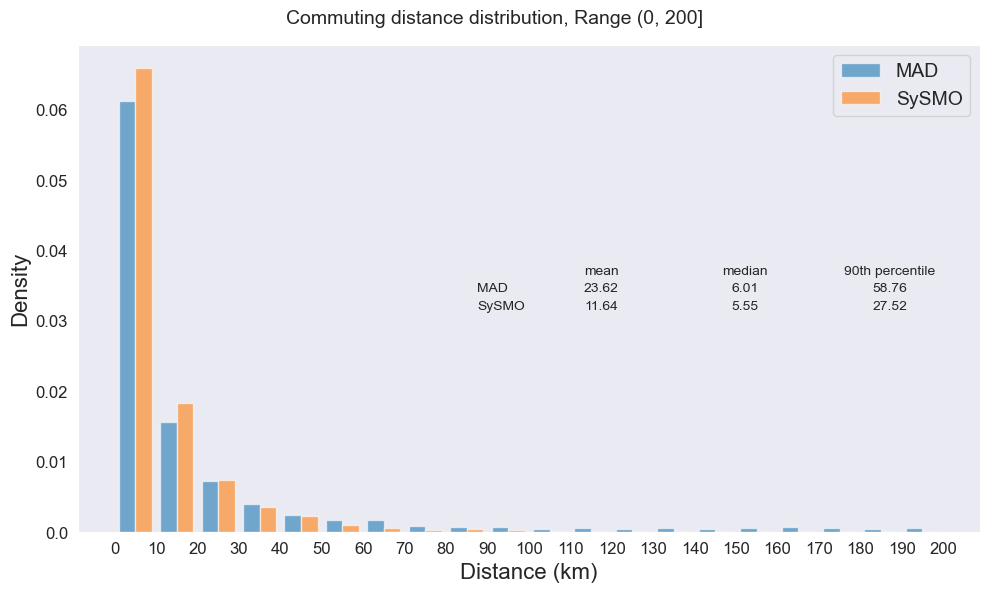

In [34]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))


ax0.hist([distances['distance(km)'][distances['distance(km)']<201],df_work['dist_work'][df_work['dist_work']<201]], density=True, histtype='bar', alpha=0.6, bins=range(0,201,10), label=['MAD','SySMO'])

ax0.grid(visible=False)

ax0.legend( prop={'size': 14}, fontsize=14)
ax0.set_xlabel('Distance (km)', fontsize=16)
ax0.set_xticks(range(0,201,10),range(0,201,10), fontsize=12)
ax0.set_yticklabels(np.arange(0.00, 0.07, 0.01), fontsize=12)
ax0.set_ylabel('Density', fontsize=16)


MAD_mean=distances['distance(km)'].mean().round(decimals=2)
MAD_median=distances['distance(km)'].median().round(decimals=2)
MAD_90=distances['distance(km)'].quantile(0.9).round(decimals=2)
SySMO_mean=df_work['dist_work'].mean().round(decimals=2)
SySMO_median=df_work['dist_work'].median().round(decimals=2)
SySMO_90=df_work['dist_work'].quantile(0.9).round(decimals=2)

ax0.table(cellText=[[MAD_mean,MAD_median,MAD_90], [SySMO_mean,SySMO_median,SySMO_90]],
          cellLoc='center',
                  colWidths = [0.16]*3,
                  rowLabels=['MAD','SySMO'],
                  colLabels=['mean','median','90th percentile'],
                  loc='center right',edges='open')


fig.suptitle('Commuting distance distribution, Range (0, 200]' , fontsize=14)
fig.tight_layout()
plt.savefig("./figures/distance_between_Home_Work_SySMO.png")
